# **Predict Stroke**

- Import Library

In [4]:
!git clone https://github.com/RizkyMlana/ML-PredictNumerical

Cloning into 'ML-PredictNumerical'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 33 (delta 3), reused 30 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 1.13 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [7]:
!pip install -r "/content/ML-PredictNumerical/requirements.txt"

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

- Load Data

In [10]:
df = pd.read_csv('/content/ML-PredictNumerical/dataset/housing.csv')

In [11]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data Preprocessing

- Handling Missing & Duplicated Values

In [12]:
df.duplicated().sum()

np.int64(0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [14]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [15]:
numeric = df.select_dtypes(include=['number']).columns
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom '{i}': {len(outliers)} outlier")

Kolom 'longitude': 0 outlier
Kolom 'latitude': 0 outlier
Kolom 'housing_median_age': 0 outlier
Kolom 'total_rooms': 1287 outlier
Kolom 'total_bedrooms': 1271 outlier
Kolom 'population': 1196 outlier
Kolom 'households': 1220 outlier
Kolom 'median_income': 681 outlier
Kolom 'median_house_value': 1071 outlier


- Outliers Handling

In [18]:
df['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [26]:

def outliersHandling(series):
  Q1 = df[series].quantile(0.25)
  Q3 = df[series].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df.loc[df[series] > upper_bound, series] = upper_bound
  df.loc[df[series] < lower_bound, series] = lower_bound
  return df


In [27]:
numeric = df.select_dtypes(include=['number']).columns

for i in numeric:
  df = outliersHandling(i)

for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom '{i}': {len(outliers)} outlier")

Kolom 'longitude': 0 outlier
Kolom 'latitude': 0 outlier
Kolom 'housing_median_age': 0 outlier
Kolom 'total_rooms': 0 outlier
Kolom 'total_bedrooms': 0 outlier
Kolom 'population': 0 outlier
Kolom 'households': 0 outlier
Kolom 'median_income': 0 outlier
Kolom 'median_house_value': 0 outlier


- Feature Engineering

In [29]:
ohe = OneHotEncoder(sparse_output=False)
encoded_data = ohe.fit_transform(df[['ocean_proximity']])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['ocean_proximity']))

## Modelling & Evaluation

In [30]:


model = Sequential([
    Dense(128, activation='relu',input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu' ),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early = EarlyStopping(patience=5, restore_best_weights=True)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[early])

NameError: name 'X_train' is not defined

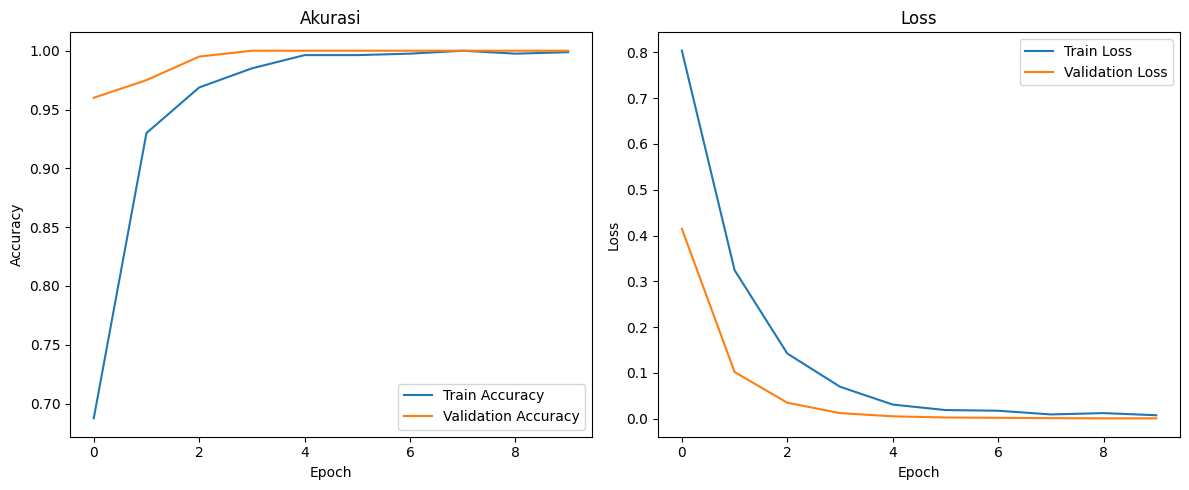

In [ ]:
# plt.figure(figsize=(12, 5))

# # Accuracy plot
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Akurasi')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [31]:
# X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# cnn_model = Sequential([
#     Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     GlobalAveragePooling1D(),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# cnn_model.fit(X_train_cnn, y_train, epochs=20, validation_split=0.2, verbose=1)

NameError: name 'X_train' is not defined

## Predict